In [1]:
import numpy as np
import pandas as pd
import statistics
import warnings
from sklearn import svm, metrics
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from matplotlib import pyplot as plt
from statistics import mean

2.
Active Learning Using Support Vector Machines

(a)
Download the banknote authentication Data Set from:
https://archive.ics.
uci.edu/ml/datasets/banknote+authentication
. Choose 472 data points ran-
domly as the test set, and the remaining 900 points as the training set. This is a
binary classification problem

In [3]:
fn = "../data/data_banknote_authentication.txt"
df = pd.read_csv(fn, sep=",", header = None, 
                names = ["Variance", "Skewness", "Curtosis","Entropy","Class"])
Train,Test = train_test_split(df, test_size = 472, random_state = None)
print (Train.shape, Test.shape)
warnings.simplefilter('ignore', UserWarning)
Y_test = Test.iloc[:,-1:]

(900, 5) (472, 5)


In [4]:
def L1_pen_Random(X,y):
    C_range = np.arange(2,10,2)
    param_grid = dict(C=C_range)
    randclf = RandomizedSearchCV(svm.LinearSVC(penalty = 'l1', dual = False, max_iter = 1000),param_grid, cv = 5)
    randclf.fit(X,y)
    return randclf.best_params_

(b)
Repeat each of the following two procedures 50 times. You will have 50 errors for
90 SVMs per each procedure.

In [10]:
#PAssinve Learning
mc = []
warnings.filterwarnings("ignore")
for i in range (50):
    Train_nn = Train.copy(deep=True)
    adding = pd.DataFrame()
    ac=[]
    
    for j in range (100):
        try:
            deducting = Train_nn.sample(10)
            for i in deducting.index:
                Train_nn = Train_nn.drop([i])       #drop randomly selected 10 data points
            adding = pd.concat([adding,deducting])

            partX_train = adding.iloc[:,:-1]
            partY_train = adding.iloc[:,-1:]

            best_params = L1_pen_Random(partX_train, partY_train.values.ravel())

            clf = svm.LinearSVC(penalty = 'l1',dual=False, max_iter = 10000, C = best_params['C'])
            clf.fit(partX_train, partY_train)
            Y_pred = clf.predict(partX_train)
            acc = acc = clf.score(partX_train, partY_train)
            ac.append(acc)
        except:
            pass

    test_error = []
    for i in ac:
        test_err = 1-i
        test_error.append(test_err)
    mc.append(test_error)

#mc will have a 50 sets of 90 test errors

In [34]:
#Active Learning
active_mc = []
Y_test = Test.iloc[:,-1:]
warnings.filterwarnings("ignore")
mcrun = 0
#Monte Carlo
while mcrun != 50:
    Train_n = Train.copy(deep=True)
    adding = pd.DataFrame()
    ac=[]

    #Sample 10 data points from trainging
#     deducting = Train_n.sample(10) -- random selection gives an error so randomly select one of each classand eight

    try:
        onee = Train_n.Class[Train_n.Class.eq(0)].sample(1).index
        twoo = Train_n.Class[Train_n.Class.eq(1)].sample(1).index 
        each = Train_n.loc[onee.union(twoo)]
        deducting = Train_n.sample(8)
        deducting = pd.concat([each,deducting])

        partX_train = deducting.iloc[:,:-1]
        partY_train = deducting.iloc[:,-1:]

        #Train the 10 data points
        best_params = L1_pen_Random(partX_train, partY_train)
        clf = svm.LinearSVC(penalty = 'l1',dual=False, max_iter = 10000, C = best_params['C'])
        clf.fit(partX_train, partY_train)


        #find CI for all data
        Train_n = Train.copy(deep=True)
        CI = clf.decision_function(Train_n.iloc[:,:-1])
        absdist = np.abs(CI)
        Train_n['CI'] = absdist


        #deducting data frame : Train_nnn
        Train_nnn = Train_n.sort_values(by=['CI'])

        while Train_nnn.shape[0] != 0:
                ten = Train_nnn.iloc[:10,:]
                adding = pd.concat([adding, ten])    # concatenating the 10 data point to adding
                #Assign X and Y
                selX_train = adding.iloc[:,:-2]
                selY_train = adding.iloc[:,-2:-1]

                best_params = L1_pen_Random(selX_train, selY_train)
                clf = svm.LinearSVC(penalty = 'l1',dual=False, max_iter = 10000, C = best_params['C'])
                clf.fit(selX_train, selY_train)
                Y_pred = clf.predict(selX_train)
                acc = clf.score(selX_train, selY_train)
                ac.append(acc)

                Train_nnn = Train_nnn.iloc[10:,:]    # 10 closest data point dropped from Train_nnn

    #Calculate Test Error
        test_error = []
        for i in ac:
            test_err = 1-i
            test_error.append(test_err)
        active_mc.append(test_error)
        mcrun = mcrun + 1

    except:
        pass


In [35]:
# Monte carlo for passive learning:
avg_pass = []
for i in range(len(mc)):
    ag = mean(mc[i])
    avg_pass.append(ag)
# avg_pass

# Monte carlo for active learning:
avg_act = []
for i in range(len(active_mc)):
    ag = mean(active_mc[i])
    avg_act.append(ag)

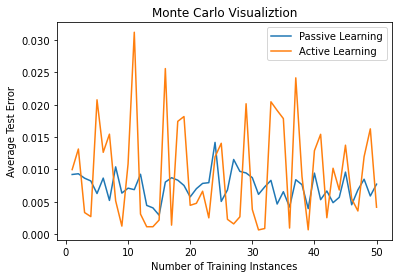

In [36]:
# Plot average test error versus number of training instances 
# for both active and passive learners on the same figure and report your conclusions

xaxis = list(range(1,51))

plt.plot(xaxis,avg_pass, label = "Passive Learning")
plt.plot(xaxis,avg_act, label = "Active Learning")

plt.xlabel('Number of Training Instances')
plt.ylabel('Average Test Error')
plt.title('Monte Carlo Visualiztion')

plt.legend()
plt.show()